# Exploration and Comparison of Transformers for Image Classification

## Zero-Shot Transfer using CLIP


Zero-shot image classification is a task that involves classifying images into different categories using a model that was not explicitly trained on data containing labeled examples from those specific categories.

### CLIP (Contrastive Language-Image Pre-Training)

The CLIP model was proposed in *Learning Transferable Visual Models From Natural Language Supervision by Alec Radford, Jong Wook Kim, Chris Hallacy, Aditya Ramesh, Gabriel Goh, Sandhini Agarwal, Girish Sastry, Amanda Askell, Pamela Mishkin, Jack Clark, Gretchen Krueger, Ilya Sutskever*. 

CLIP (Contrastive Language-Image Pre-Training) is a neural network trained on a variety of (image, text) pairs. It can be instructed in natural language to predict the most relevant text snippet, given an image, without directly optimizing for the task, similarly to the zero-shot capabilities of GPT-2 and 3.

https://arxiv.org/abs/2103.0002030

### Prerequisites

Load necessary packages.

In [2]:
import os
os.chdir('../../../')

import torch

import pandas as pd

from datasets import load_dataset

from src.dataset_builder import ImageDataset
from src.models import CLIP
from src.train import *

from utils.config import Config
from utils.train_utils import *
from utils.models_utils import *
from utils.visualization_utils import *
from utils.data_utils import *

Check if there is GPU available.

In [3]:
get_gpu_info()

GPU 0: NVIDIA A100 80GB PCIe MIG 2g.20gb
VRAM: 19.50 GB


Set manual seed for reproducibility.

In [4]:
id = 10
torch.manual_seed(10)

### Model

Load pre-trained CLIP model.

In [5]:
model = CLIP()

Print the number of parameters.

In [6]:
get_model_params(model)

Parameters: 149.62M


Load CLIP image processor and tokenizer used for image and text pre-processing.

In [7]:
processor, tokenizer = get_clip_processor_and_tokenizer()

### Data Preprocessing

Load each dataset and clean its labels.

CLIP's processor and tokenizer is automatically applied to images and corresponding texts.

Since this is a zero-shot transfer experiment, only the test/validation split is needed.

#### RESISC45

In [8]:
resisc45 = load_dataset('timm/resisc45')
clean_labels(resisc45, name='resisc45')
resisc45 = ImageDataset(
    dataset=resisc45['test'],
    processor=processor,
    tokenizer=tokenizer,
    create_captions=True,
    prompt="{}",
)
resisc45.dataset

Dataset({
    features: ['image', 'label', 'image_id'],
    num_rows: 6300
})

#### Food-101

In [9]:
food101 = load_dataset('ethz/food101')
clean_labels(food101, name='food101')
food101 = ImageDataset(
    dataset=food101['validation'],
    processor=processor,
    tokenizer=tokenizer,
    create_captions=True,
    prompt="{}",
)
food101.dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 25250
})

#### FER2013

In [10]:
fer2013 = load_dataset('AutumnQiu/fer2013')
clean_labels(fer2013, name='fer2013')
fer2013 = ImageDataset(
    dataset=fer2013['test'],
    processor=processor,
    tokenizer=tokenizer,
    create_captions=True,
    prompt="{}",
)
fer2013.dataset

Dataset({
    features: ['label', 'image'],
    num_rows: 3589
})

#### PCam

In [11]:
pcam = load_dataset('zacharielegault/PatchCamelyon')
clean_labels(pcam, name='pcam')
pcam = ImageDataset(
    dataset=pcam['test'],
    processor=processor,
    tokenizer=tokenizer,
    create_captions=True,
    prompt="{}",
)
pcam.dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 32768
})

#### SUN397

In [12]:
sun397 = load_dataset('dpdl-benchmark/sun397')
clean_labels(sun397, name='sun397')
sun397 = ImageDataset(
    dataset=sun397['test'],
    processor=processor,
    tokenizer=tokenizer,
    create_captions=True,
    prompt="{}",
)
sun397.dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 21750
})

#### DTD

In [13]:
dtd = load_dataset('tanganke/dtd')
clean_labels(dtd, name='dtd')
dtd = ImageDataset(
    dataset=dtd['test'],
    processor=processor,
    tokenizer=tokenizer,
    create_captions=True,
    prompt="{}"
)
dtd.dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 1880
})

### Config

Create a config for experiments and print its settings.

Since this experiment involves no training, the default settings can be applied. None of them except criterion are going to be used.

In [14]:
config = Config()
config.get_settings()

{'device': 'cuda',
 'criterion': CrossEntropyLoss(),
 'batch_size': 8,
 'lr': 5e-05,
 'num_epochs': 5,
 'optimizer': torch.optim.adam.Adam,
 'weight_decay': 0.0001,
 'dropout_rate': 0.1,
 'early_stopping': {'enabled': False, 'patience': 3, 'delta': 0},
 'gradient_clipping': {'enabled': False, 'max_norm': 0},
 'scheduler': {'enabled': False,
  'warmup_epochs': 0,
  'eta_min': 0,
  'linear_start_factor': 0.1,
  'linear_end_factor': 1.0}}

Create empty array to store dataset accuracies for each experiment.

In [15]:
resisc45_accs = []
food101_accs = []
fer2013_accs = []
pcam_accs = []
sun397_accs = []
dtd_accs = []

### Experiment #1 - Class label

This experiment involes only using class label as text input.

Examples of text input:
- terrace
- overpass
- snowberg
- steak
- skatepark

#### RESISC45

In [16]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = evaluate_model(
    model,
    resisc45,
    config,
    zero_shot=True
)

100%|██████████| 788/788 [00:36<00:00, 21.45it/s]

Zero-shot evaluation completed: loss: 1.6380 | acc: 0.5440


In [17]:
resisc45_accs.append(resisc45_acc)

In [18]:
get_top_5_accuracies(resisc45_per_class_acc)

[('sea ice', 0.9867549668874173),
 ('golf course', 0.9836065573770492),
 ('baseball diamond', 0.943089430894309),
 ('mobile home park', 0.926829268292683),
 ('rectangular farmland', 0.9111111111111111)]

In [19]:
get_bottom_5_accuracies(resisc45_per_class_acc)

[('chaparral', 0.0),
 ('meadow', 0.0),
 ('terrace', 0.0),
 ('snowberg', 0.031446540880503145),
 ('overpass', 0.08)]

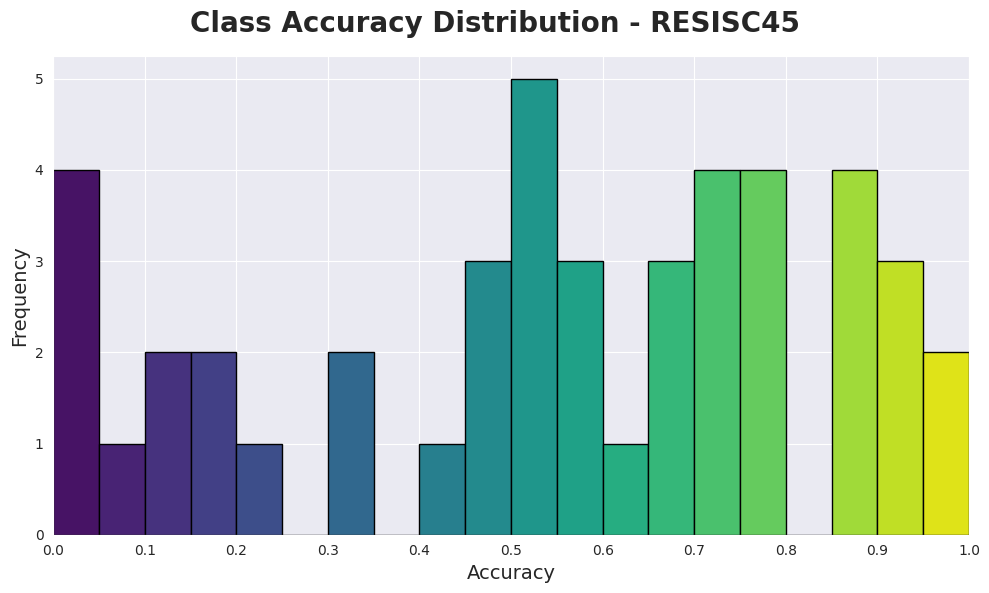

In [20]:
plot_per_class_accuracies(
    resisc45_per_class_acc,
    'RESISC45',
    num_bins=20
)

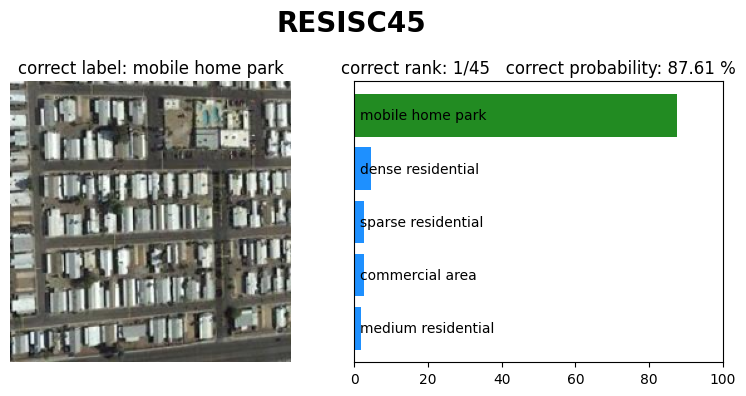

In [21]:
visualize_zero_shot_predict(
    model=model, 
    image=resisc45.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=resisc45.get_captions(),
    labels=resisc45.get_labels(),
    label=resisc45.get_label(id),
    prompt=resisc45.get_prompt(),
    title='RESISC45',
    config=config,
) 

#### Food-101

In [22]:
food101_loss, food101_acc, food101_per_class_acc = evaluate_model(
    model,
    food101,
    config,
    zero_shot=True
)

 15%|█▌        | 474/3157 [00:31<02:58, 15.02it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 3157/3157 [03:29<00:00, 15.08it/s]


Zero-shot evaluation completed: loss: 0.4645 | acc: 0.8667


In [23]:
food101_accs.append(food101_acc)

In [24]:
get_top_5_accuracies(food101_per_class_acc)

[('edamame', 1.0),
 ('lobster roll sandwich', 0.992),
 ('seaweed salad', 0.992),
 ('oysters', 0.984),
 ('macarons', 0.976)]

In [25]:
get_bottom_5_accuracies(food101_per_class_acc)

[('ravioli', 0.164),
 ('steak', 0.508),
 ('hamburger', 0.66),
 ('tacos', 0.664),
 ('pork chop', 0.672)]

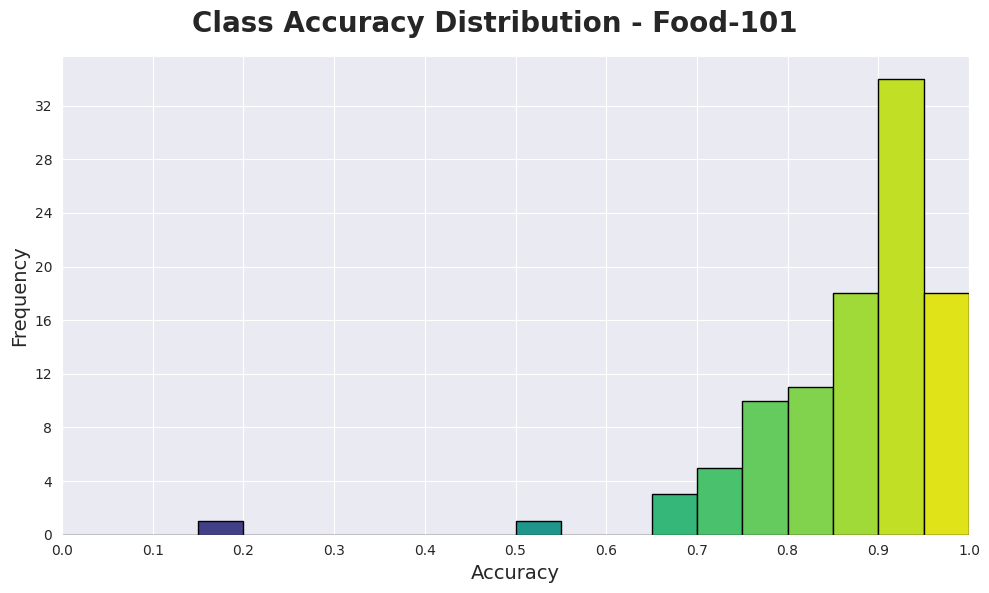

In [26]:
plot_per_class_accuracies(
    food101_per_class_acc,
    'Food-101',
    num_bins=20
)

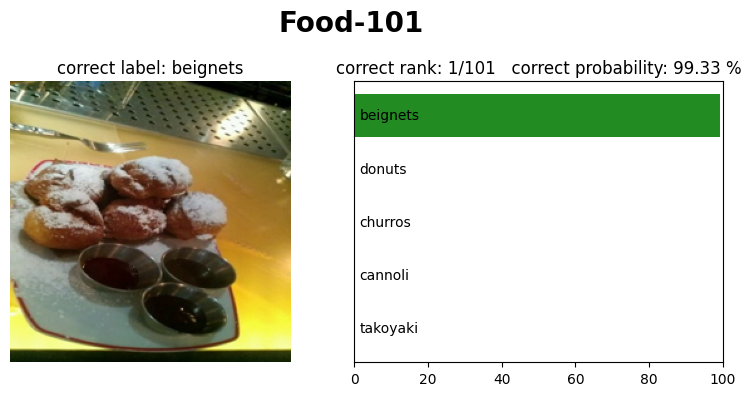

In [27]:
visualize_zero_shot_predict(
    model=model, 
    image=food101.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=food101.get_captions(),
    labels=food101.get_labels(),
    label=food101.get_label(id),
    prompt=food101.get_prompt(),
    title='Food-101',
    config=config
) 

#### FER2013

In [28]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = evaluate_model(
    model,
    fer2013,
    config,
    zero_shot=True
)

100%|██████████| 449/449 [00:16<00:00, 26.73it/s]

Zero-shot evaluation completed: loss: 1.8606 | acc: 0.4085


In [29]:
fer2013_accs.append(fer2013_acc)

In [30]:
fer2013_per_class_acc

{'angry': 0.8553971486761711,
 'disgust': 0.21818181818181817,
 'fear': 0.09848484848484848,
 'happy': 0.8714448236632537,
 'sad': 0.03198653198653199,
 'surprise': 0.46634615384615385,
 'neutral': 0.004792332268370607}

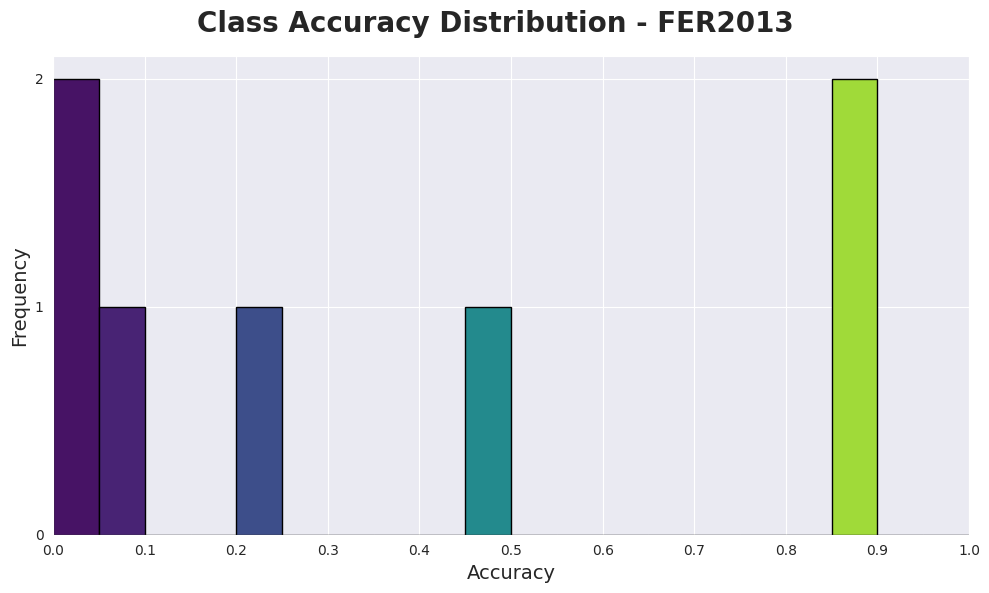

In [31]:
plot_per_class_accuracies(
    fer2013_per_class_acc,
    'FER2013',
    num_bins=20
)

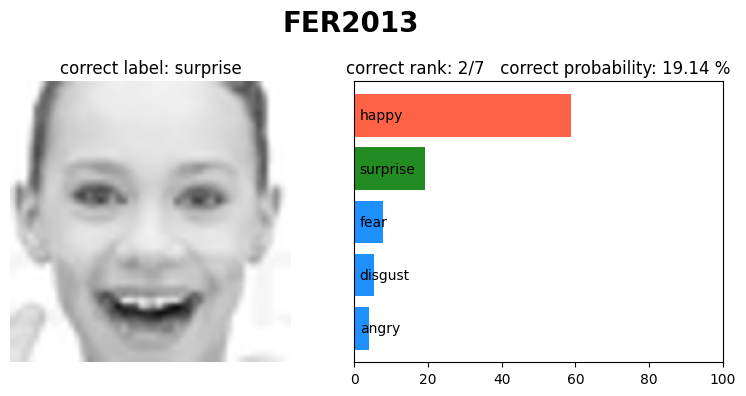

In [32]:
visualize_zero_shot_predict(
    model=model, 
    image=fer2013.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=fer2013.get_captions(),
    labels=fer2013.get_labels(),
    label=fer2013.get_label(id),
    prompt=fer2013.get_prompt(),
    title='FER2013',
    config=config
)

#### PCam

In [33]:
pcam_loss, pcam_acc, pcam_per_class_acc = evaluate_model(
    model,
    pcam,
    config,
    zero_shot=True
)

100%|██████████| 4096/4096 [02:49<00:00, 24.22it/s]

Zero-shot evaluation completed: loss: 0.6906 | acc: 0.5585


In [34]:
pcam_accs.append(pcam_acc)

In [35]:
pcam_per_class_acc

{'healthy lymph node tissue': 0.505277286315661,
 'lymph node tumor tissue': 0.6117115466813213}

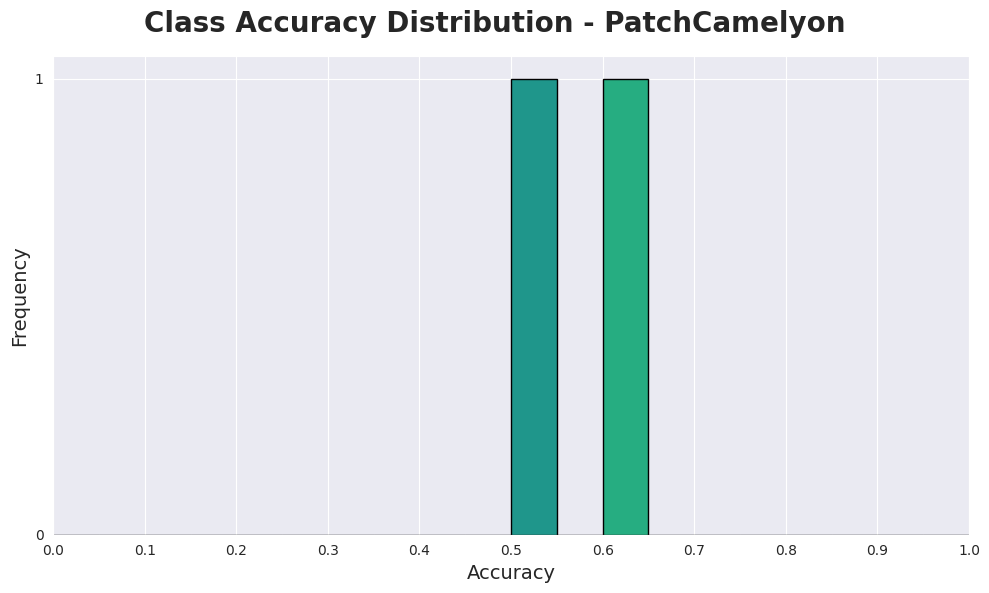

In [36]:
plot_per_class_accuracies(
    pcam_per_class_acc,
    'PatchCamelyon',
    num_bins=20
)

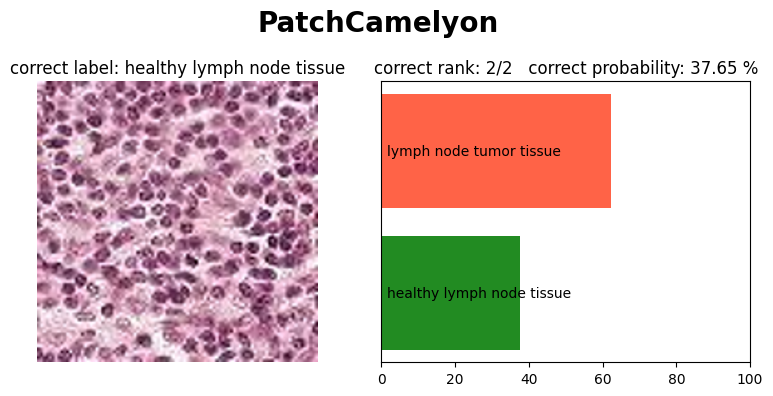

In [37]:
visualize_zero_shot_predict(
    model=model, 
    image=pcam.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=pcam.get_captions(),
    labels=pcam.get_labels(),
    label=pcam.get_label(id),
    prompt=pcam.get_prompt(),
    title='PatchCamelyon',
    config=config
)

#### SUN397

In [38]:
sun397_loss, sun397_acc, sun397_per_class_acc = evaluate_model(
    model,
    sun397,
    config,
    zero_shot=True
)

100%|██████████| 2719/2719 [03:58<00:00, 11.41it/s]


Zero-shot evaluation completed: loss: 1.4444 | acc: 0.6109


In [39]:
sun397_accs.append(sun397_acc)

In [40]:
get_top_5_accuracies(sun397_per_class_acc)

[('heliport', 1.0),
 ('kindergarden classroom', 1.0),
 ('raceway', 1.0),
 ('rock arch', 1.0),
 ('skatepark', 1.0)]

In [41]:
get_bottom_5_accuracies(sun397_per_class_acc)

[('bazaar (outdoor)', 0.0),
 ('berth', 0.0),
 ('clean room', 0.0),
 ('conference center', 0.0),
 ('delicatessen', 0.0)]

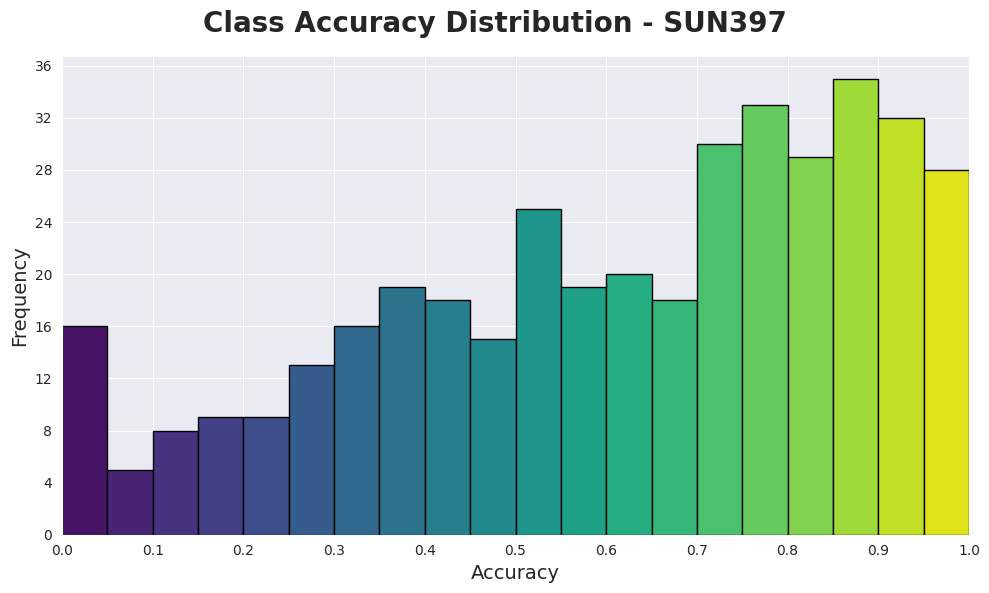

In [42]:
plot_per_class_accuracies(
    sun397_per_class_acc,
    'SUN397',
    num_bins=20
)

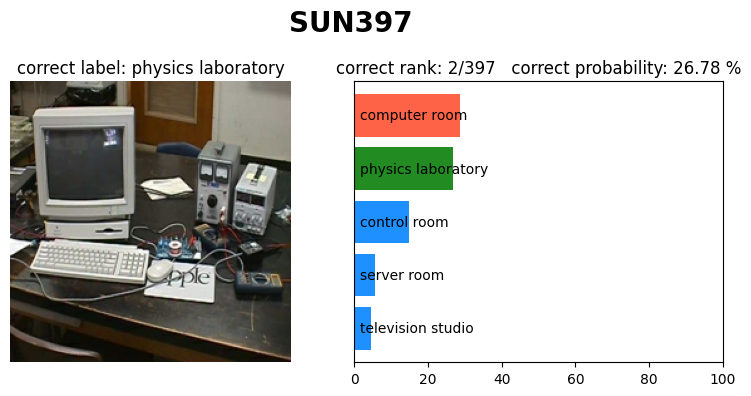

In [43]:
visualize_zero_shot_predict(
    model=model, 
    image=sun397.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=sun397.get_captions(),
    labels=sun397.get_labels(),
    label=sun397.get_label(id),
    prompt=sun397.get_prompt(),
    title='SUN397',
    config=config,
)

#### DTD

In [44]:
dtd_loss, dtd_acc, dtd_per_class_acc = evaluate_model(
    model,
    dtd,
    config,
    zero_shot=True
)

100%|██████████| 235/235 [00:15<00:00, 15.30it/s]

Zero-shot evaluation completed: loss: 2.2435 | acc: 0.4468


In [45]:
dtd_accs.append(dtd_acc)

In [46]:
get_top_5_accuracies(dtd_per_class_acc)

[('chequered', 0.975),
 ('cobwebbed', 0.975),
 ('crystalline', 0.975),
 ('paisley', 0.975),
 ('marbled', 0.9)]

In [47]:
get_bottom_5_accuracies(dtd_per_class_acc)

[('banded', 0.0),
 ('bumpy', 0.0),
 ('flecked', 0.0),
 ('lacelike', 0.0),
 ('pitted', 0.0)]

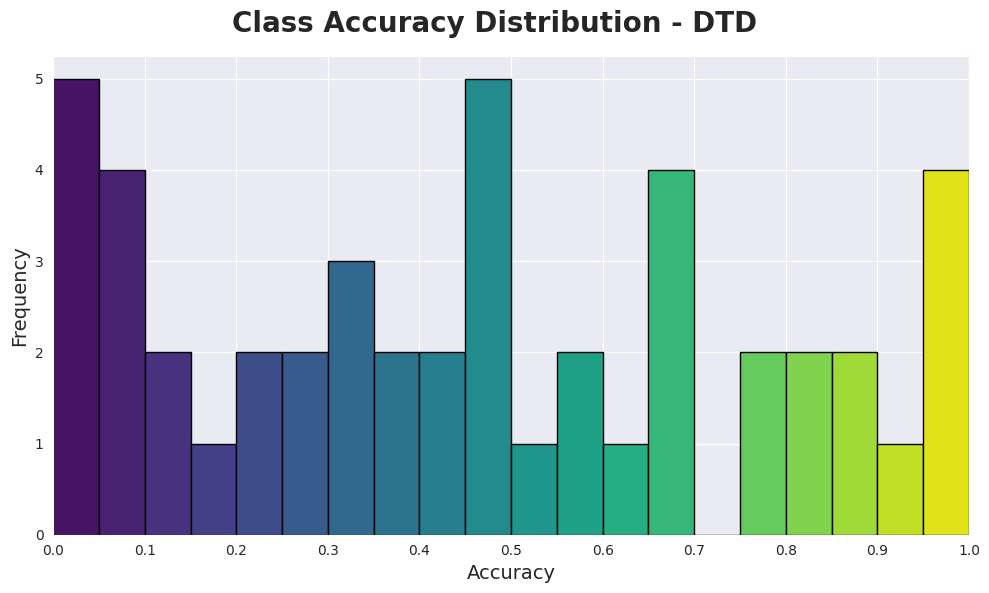

In [48]:
plot_per_class_accuracies(
    dtd_per_class_acc,
    'DTD',
    num_bins=20
)

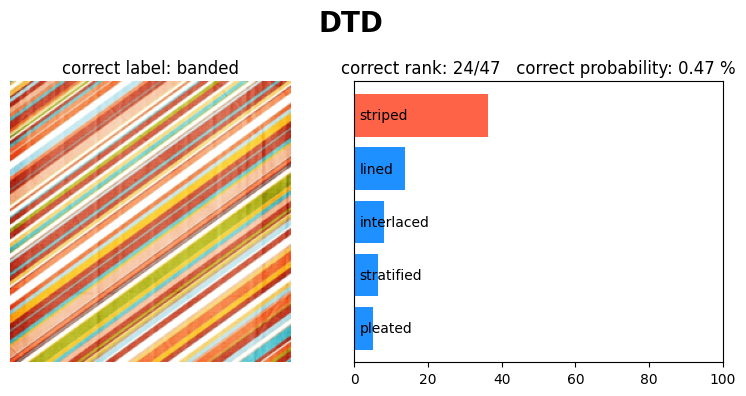

In [49]:
visualize_zero_shot_predict(
    model=model, 
    image=dtd.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=dtd.get_captions(),
    labels=dtd.get_labels(),
    label=dtd.get_label(id),
    prompt=dtd.get_prompt(),
    title='DTD',
    config=config
)

### Experiment #2 - Basic template

This experiment involes using a basic prompt template **"a photo of {}."** as text input.

Examples of text input:
- a photo of terrace
- a photo of overpass
- a photo of snowberg
- a photo of steak
- a photo of skatepark

#### RESISC45

In [50]:
resisc45.set_prompt("a photo of {}.")

In [51]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = evaluate_model(
    model,
    resisc45,
    config,
    zero_shot=True
)

100%|██████████| 788/788 [00:35<00:00, 22.16it/s]

Zero-shot evaluation completed: loss: 1.5047 | acc: 0.5657


In [52]:
resisc45_accs.append(resisc45_acc)

In [53]:
get_top_5_accuracies(resisc45_per_class_acc)

[('golf course', 0.9754098360655737),
 ('sea ice', 0.9735099337748344),
 ('island', 0.9424460431654677),
 ('circular farmland', 0.910958904109589),
 ('parking lot', 0.9037037037037037)]

In [54]:
get_bottom_5_accuracies(resisc45_per_class_acc)

[('chaparral', 0.0),
 ('meadow', 0.0),
 ('terrace', 0.0),
 ('sparse residential', 0.1076923076923077),
 ('medium residential', 0.10884353741496598)]

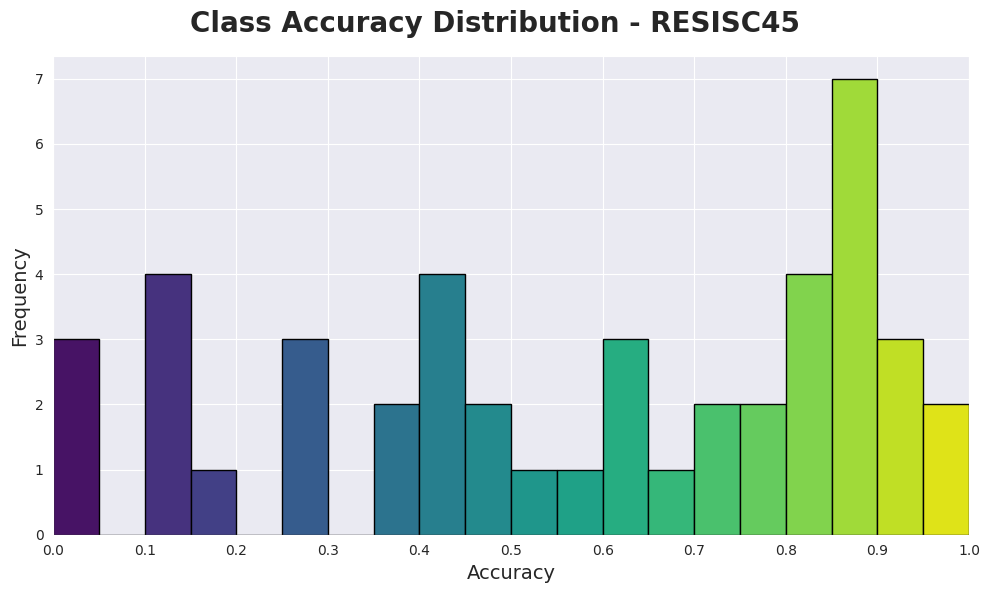

In [55]:
plot_per_class_accuracies(
    resisc45_per_class_acc,
    'RESISC45',
    num_bins=20
)

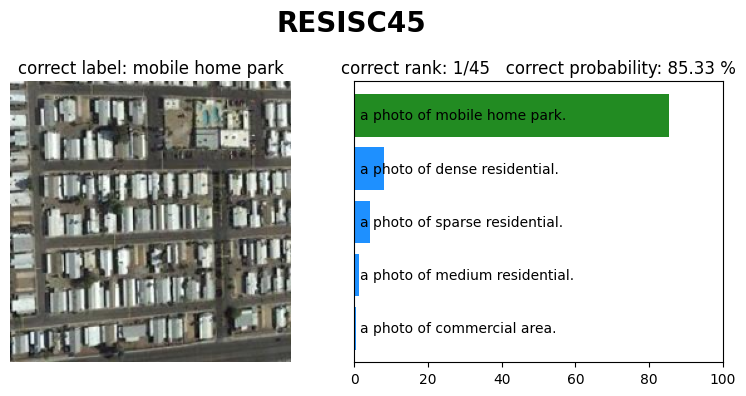

In [56]:
visualize_zero_shot_predict(
    model=model, 
    image=resisc45.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=resisc45.get_captions(),
    labels=resisc45.get_labels(),
    label=resisc45.get_label(id),
    prompt=resisc45.get_prompt(),
    title='RESISC45',
    config=config,
) 

#### Food-101

In [57]:
food101.set_prompt("a photo of {}.")

In [58]:
food101_loss, food101_acc, food101_per_class_acc = evaluate_model(
    model,
    food101,
    config,
    zero_shot=True
)

 15%|█▌        | 474/3157 [00:33<03:02, 14.73it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 3157/3157 [03:38<00:00, 14.48it/s]


Zero-shot evaluation completed: loss: 0.4622 | acc: 0.8657


In [59]:
food101_accs.append(food101_acc)

In [60]:
get_top_5_accuracies(food101_per_class_acc)

[('edamame', 0.996),
 ('oysters', 0.988),
 ('seaweed salad', 0.988),
 ('caesar salad', 0.984),
 ('lobster roll sandwich', 0.984)]

In [61]:
get_bottom_5_accuracies(food101_per_class_acc)

[('waffles', 0.256),
 ('ravioli', 0.292),
 ('steak', 0.396),
 ('pork chop', 0.592),
 ('ice cream', 0.628)]

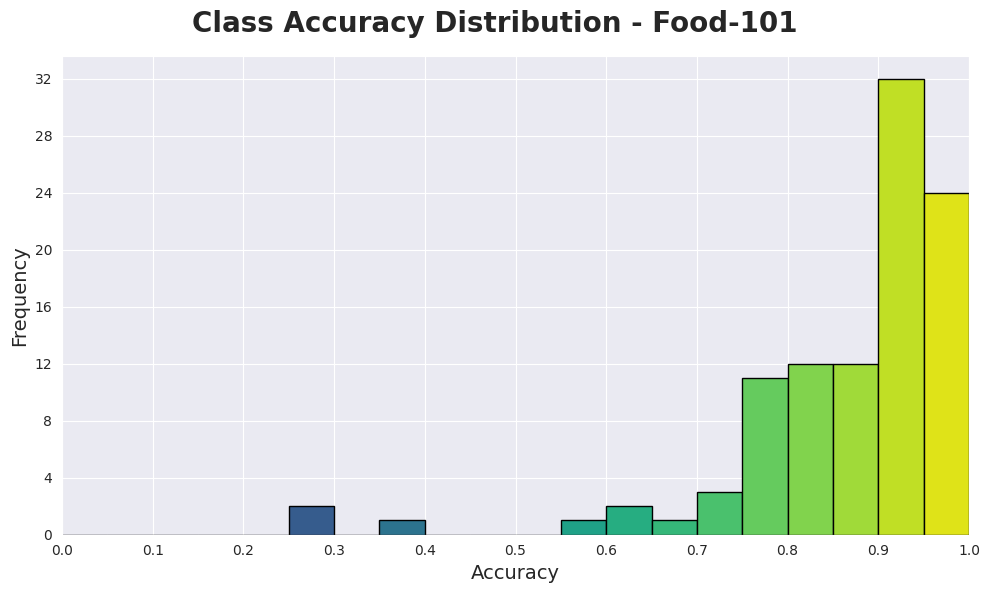

In [62]:
plot_per_class_accuracies(
    food101_per_class_acc,
    'Food-101',
    num_bins=20
)

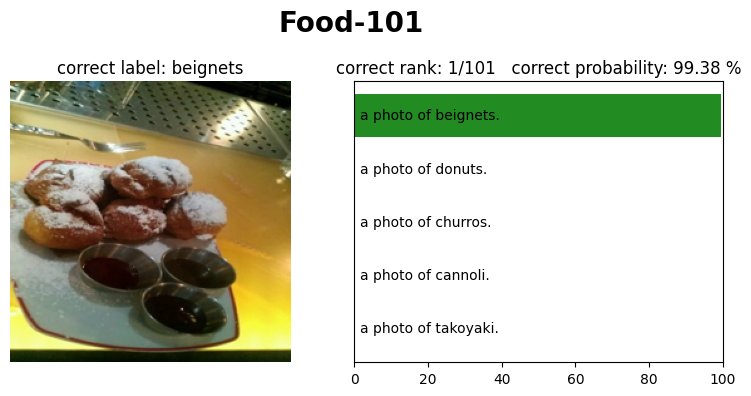

In [63]:
visualize_zero_shot_predict(
    model=model, 
    image=food101.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=food101.get_captions(),
    labels=food101.get_labels(),
    label=food101.get_label(id),
    prompt=food101.get_prompt(),
    title='Food-101',
    config=config
) 

#### FER2013

In [64]:
fer2013.set_prompt("a photo of {}.")

In [65]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = evaluate_model(
    model,
    fer2013,
    config,
    zero_shot=True
)

100%|██████████| 449/449 [00:17<00:00, 25.29it/s]

Zero-shot evaluation completed: loss: 1.5951 | acc: 0.4547


In [66]:
fer2013_accs.append(fer2013_acc)

In [67]:
fer2013_per_class_acc

{'angry': 0.8044806517311609,
 'disgust': 0.3090909090909091,
 'fear': 0.07575757575757576,
 'happy': 0.8873720136518771,
 'sad': 0.13468013468013468,
 'surprise': 0.4831730769230769,
 'neutral': 0.1900958466453674}

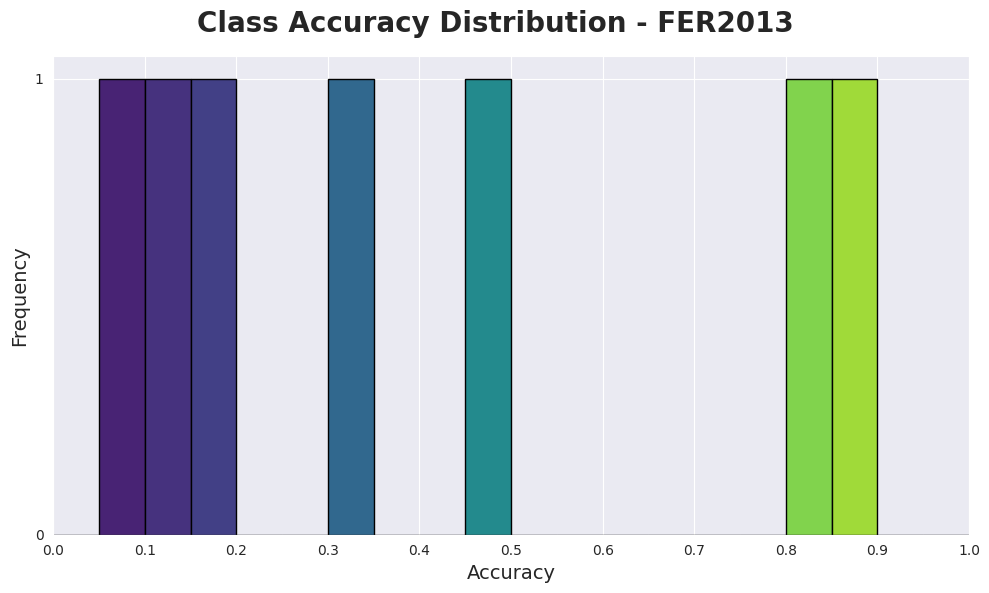

In [68]:
plot_per_class_accuracies(
    fer2013_per_class_acc,
    'FER2013',
    num_bins=20
)

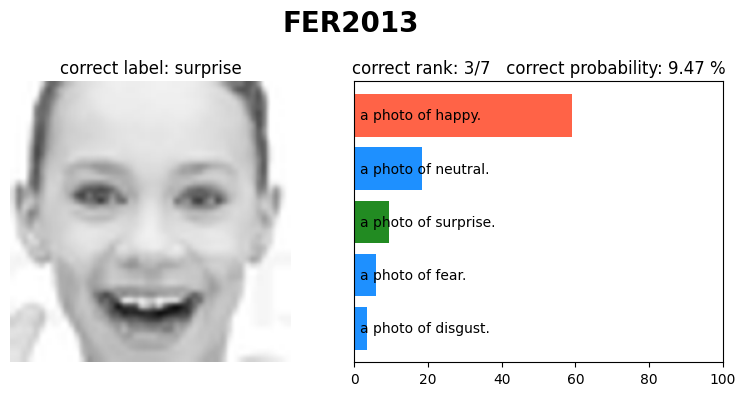

In [69]:
visualize_zero_shot_predict(
    model=model, 
    image=fer2013.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=fer2013.get_captions(),
    labels=fer2013.get_labels(),
    label=fer2013.get_label(id),
    prompt=fer2013.get_prompt(),
    title='FER2013',
    config=config
)

#### PCam

In [70]:
pcam.set_prompt("a photo of {}.")

In [71]:
pcam_loss, pcam_acc, pcam_per_class_acc = evaluate_model(
    model,
    pcam,
    config,
    zero_shot=True
)

100%|██████████| 4096/4096 [02:38<00:00, 25.90it/s]

Zero-shot evaluation completed: loss: 0.6889 | acc: 0.5538


In [72]:
pcam_accs.append(pcam_acc)

In [73]:
pcam_per_class_acc

{'healthy lymph node tissue': 0.4476236959306937,
 'lymph node tumor tissue': 0.6600720522684252}

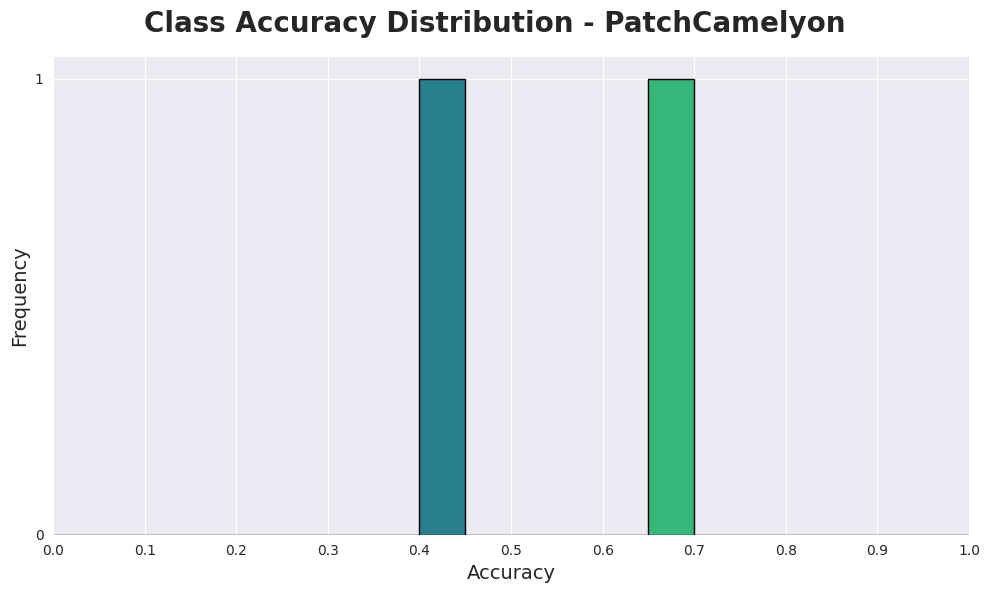

In [74]:
plot_per_class_accuracies(
    pcam_per_class_acc,
    'PatchCamelyon',
    num_bins=20
)

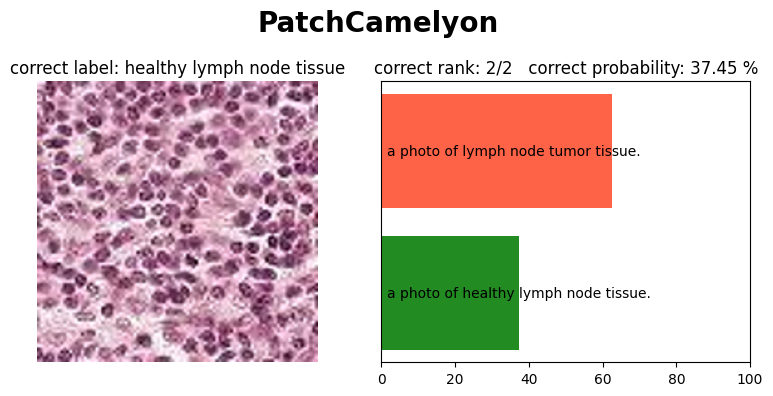

In [75]:
visualize_zero_shot_predict(
    model=model, 
    image=pcam.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=pcam.get_captions(),
    labels=pcam.get_labels(),
    label=pcam.get_label(id),
    prompt=pcam.get_prompt(),
    title='PatchCamelyon',
    config=config
)

#### SUN397

In [76]:
sun397.set_prompt("a photo of {}.")

In [77]:
sun397_loss, sun397_acc, sun397_per_class_acc = evaluate_model(
    model,
    sun397,
    config,
    zero_shot=True
)

100%|██████████| 2719/2719 [04:17<00:00, 10.55it/s]


Zero-shot evaluation completed: loss: 1.3508 | acc: 0.6392


In [78]:
sun397_accs.append(sun397_acc)

In [79]:
get_top_5_accuracies(sun397_per_class_acc)

[('aquarium', 1.0),
 ('engine room', 1.0),
 ('landing deck', 1.0),
 ('parking garage (indoor)', 1.0),
 ('rock arch', 1.0)]

In [80]:
get_bottom_5_accuracies(sun397_per_class_acc)

[('berth', 0.0),
 ('conference center', 0.0),
 ('dinette (vehicle)', 0.0),
 ('fairway', 0.0),
 ('galley', 0.0)]

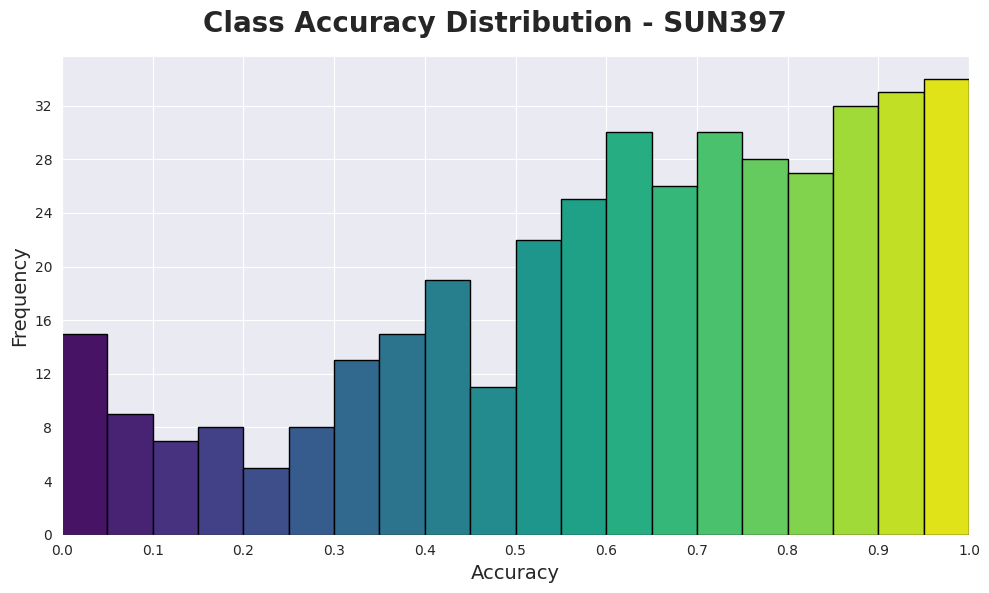

In [81]:
plot_per_class_accuracies(
    sun397_per_class_acc,
    'SUN397',
    num_bins=20
)

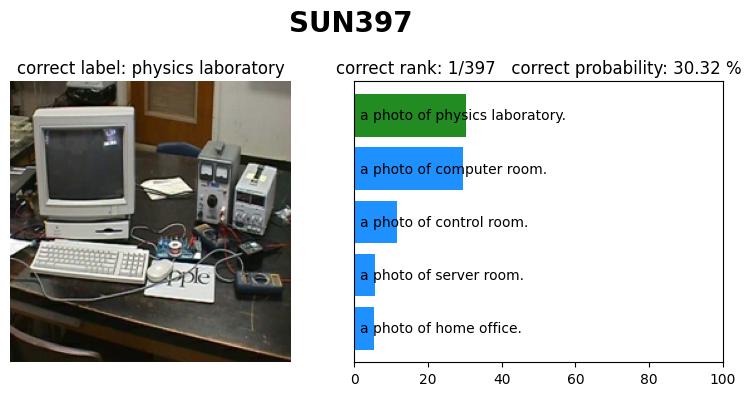

In [82]:
visualize_zero_shot_predict(
    model=model, 
    image=sun397.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=sun397.get_captions(),
    labels=sun397.get_labels(),
    label=sun397.get_label(id),
    prompt=sun397.get_prompt(),
    title='SUN397',
    config=config,
)

#### DTD

In [83]:
dtd.set_prompt("a photo of {}.")

In [84]:
dtd_loss, dtd_acc, dtd_per_class_acc = evaluate_model(
    model,
    dtd,
    config,
    zero_shot=True
)

100%|██████████| 235/235 [00:15<00:00, 15.06it/s]

Zero-shot evaluation completed: loss: 2.2587 | acc: 0.4090


In [85]:
dtd_accs.append(dtd_acc)

In [86]:
get_top_5_accuracies(dtd_per_class_acc)

[('crystalline', 1.0),
 ('chequered', 0.975),
 ('cobwebbed', 0.925),
 ('polka-dotted', 0.9),
 ('marbled', 0.875)]

In [87]:
get_bottom_5_accuracies(dtd_per_class_acc)

[('bumpy', 0.0),
 ('flecked', 0.0),
 ('interlaced', 0.0),
 ('lacelike', 0.0),
 ('pitted', 0.0)]

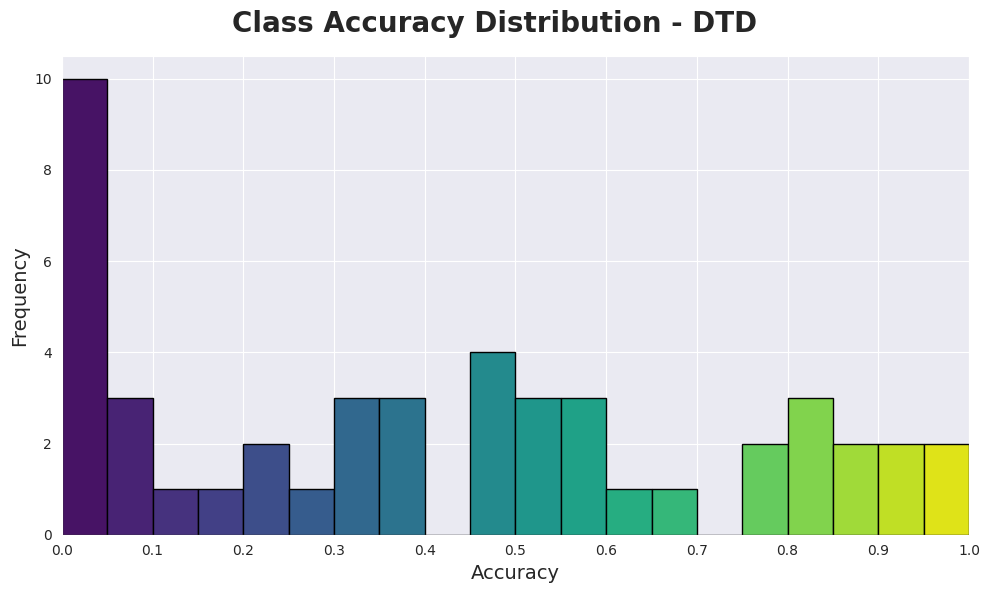

In [88]:
plot_per_class_accuracies(
    dtd_per_class_acc,
    'DTD',
    num_bins=20
)

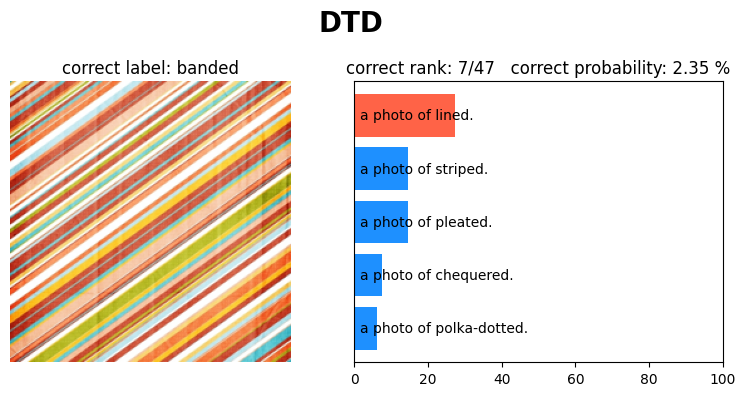

In [89]:
visualize_zero_shot_predict(
    model=model, 
    image=dtd.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=dtd.get_captions(),
    labels=dtd.get_labels(),
    label=dtd.get_label(id),
    prompt=dtd.get_prompt(),
    title='DTD',
    config=config
)

### Experiment #3 - Custom template

This experiment involes using a special, handcrafted descriptive prompt for each dataset.

Templates used:
- **RESISC45** - a high-quality image of a {}, taken by a satellite.
- **Food-101** - a close-up photo of a freshly prepared {} dish, served on a plate.
- **FER2013** - an image capturing a person with a {} look on their face.
- **PCam** - a close-up image of a {} sample under a microscope.
- **SUN397** - a clear photo capturing a {}.
- **DTD** - a detailed photo of a {} pattern.

#### RESISC45

In [90]:
resisc45.set_prompt("a high-quality image of a {}, taken by a satellite.")

In [91]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = evaluate_model(
    model,
    resisc45,
    config,
    zero_shot=True
)

100%|██████████| 788/788 [00:38<00:00, 20.35it/s]

Zero-shot evaluation completed: loss: 1.3420 | acc: 0.5956


In [92]:
resisc45_accs.append(resisc45_acc)

In [93]:
get_top_5_accuracies(resisc45_per_class_acc)

[('golf course', 0.9836065573770492),
 ('mobile home park', 0.975609756097561),
 ('beach', 0.9461538461538461),
 ('stadium', 0.9295774647887324),
 ('parking lot', 0.9185185185185185)]

In [94]:
get_bottom_5_accuracies(resisc45_per_class_acc)

[('chaparral', 0.0),
 ('sparse residential', 0.007692307692307693),
 ('terrace', 0.047244094488188976),
 ('dense residential', 0.11805555555555555),
 ('airplane', 0.11834319526627218)]

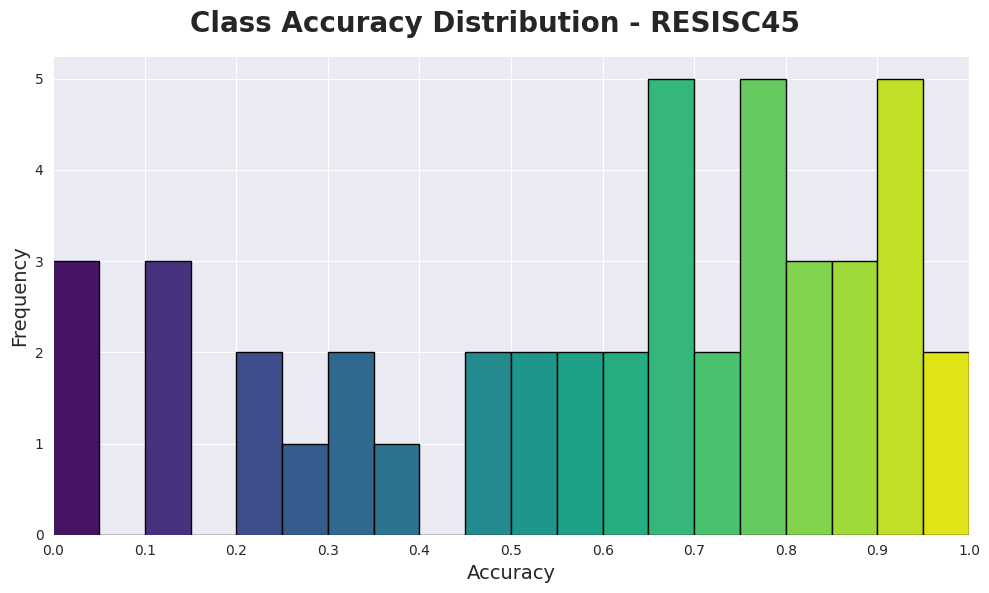

In [95]:
plot_per_class_accuracies(
    resisc45_per_class_acc,
    'RESISC45',
    num_bins=20
)

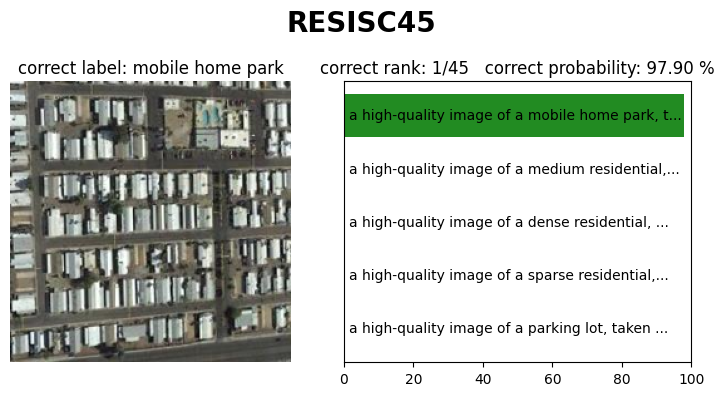

In [96]:
visualize_zero_shot_predict(
    model=model, 
    image=resisc45.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=resisc45.get_captions(),
    labels=resisc45.get_labels(),
    label=resisc45.get_label(id),
    prompt=resisc45.get_prompt(),
    title='RESISC45',
    config=config,
) 

#### Food-101

In [97]:
food101.set_prompt("a close-up photo of a freshly prepared {} dish, served on a plate.")

In [98]:
food101_loss, food101_acc, food101_per_class_acc = evaluate_model(
    model,
    food101,
    config,
    zero_shot=True
)

 15%|█▌        | 474/3157 [00:37<03:32, 12.65it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 3157/3157 [04:04<00:00, 12.91it/s]


Zero-shot evaluation completed: loss: 0.4045 | acc: 0.8849


In [99]:
food101_accs.append(food101_acc)

In [100]:
get_top_5_accuracies(food101_per_class_acc)

[('edamame', 1.0),
 ('macarons', 0.996),
 ('oysters', 0.988),
 ('frozen yogurt', 0.984),
 ('lobster roll sandwich', 0.984)]

In [101]:
get_bottom_5_accuracies(food101_per_class_acc)

[('steak', 0.48),
 ('chocolate mousse', 0.636),
 ('foie gras', 0.656),
 ('apple pie', 0.664),
 ('ice cream', 0.7)]

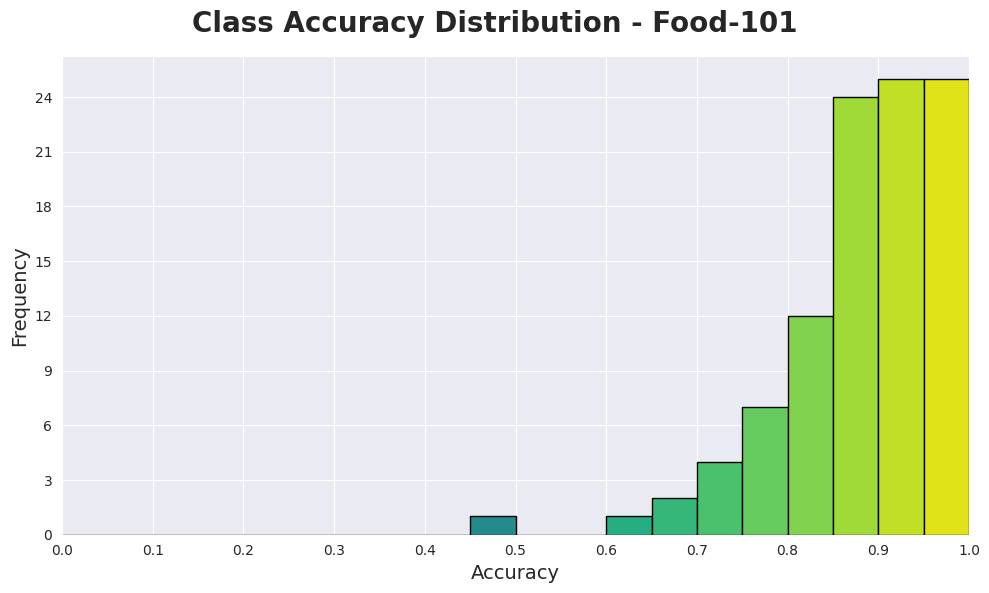

In [102]:
plot_per_class_accuracies(
    food101_per_class_acc,
    'Food-101',
    num_bins=20
)

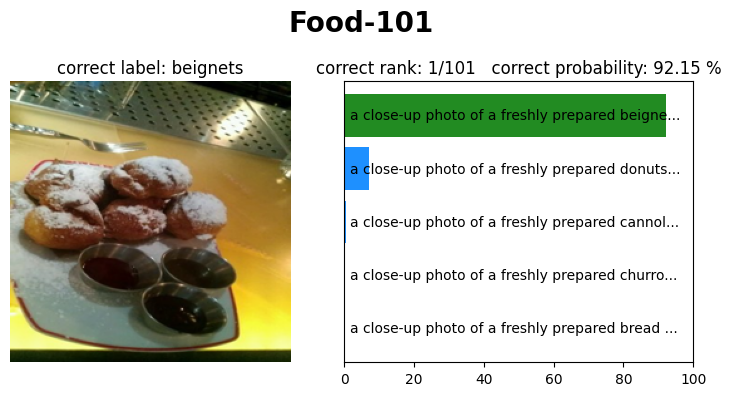

In [103]:
visualize_zero_shot_predict(
    model=model, 
    image=food101.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=food101.get_captions(),
    labels=food101.get_labels(),
    label=food101.get_label(id),
    prompt=food101.get_prompt(),
    title='Food-101',
    config=config
) 

#### FER2013

In [104]:
fer2013.set_prompt("an image capturing a person with a {} look on their face.")

In [105]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = evaluate_model(
    model,
    fer2013,
    config,
    zero_shot=True
)

100%|██████████| 449/449 [00:17<00:00, 25.99it/s]

Zero-shot evaluation completed: loss: 1.4485 | acc: 0.4586


In [106]:
fer2013_accs.append(fer2013_acc)

In [107]:
fer2013_per_class_acc

{'angry': 0.38085539714867617,
 'disgust': 0.5818181818181818,
 'fear': 0.30492424242424243,
 'happy': 0.6291240045506257,
 'sad': 0.5841750841750841,
 'surprise': 0.6730769230769231,
 'neutral': 0.13738019169329074}

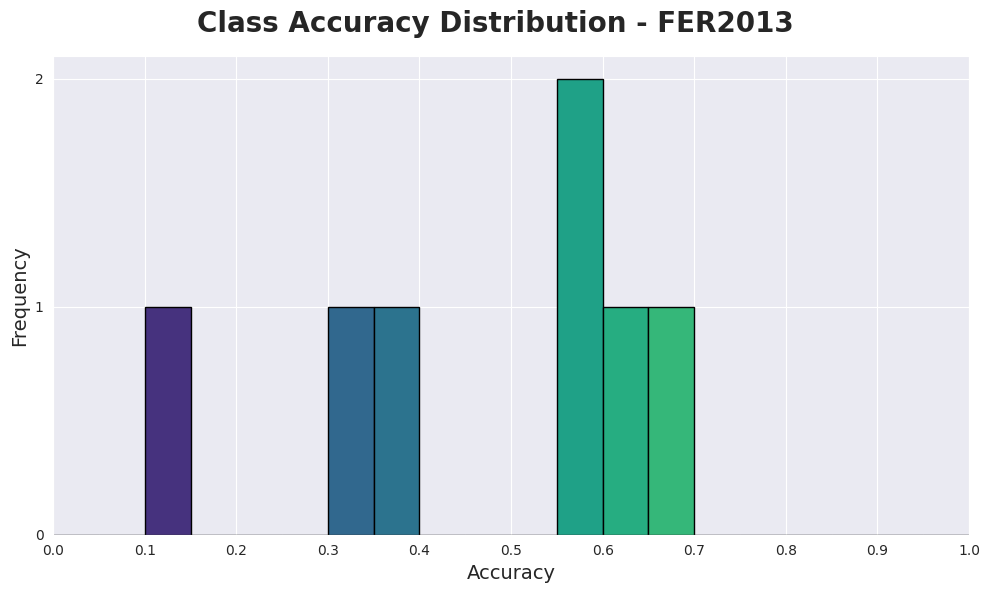

In [108]:
plot_per_class_accuracies(
    fer2013_per_class_acc,
    'FER2013',
    num_bins=20
)

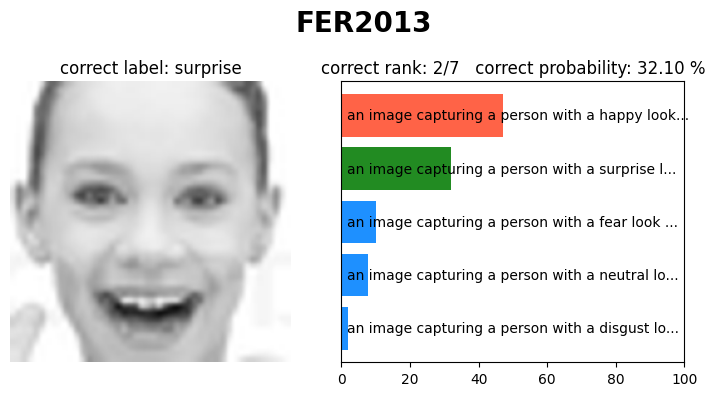

In [109]:
visualize_zero_shot_predict(
    model=model, 
    image=fer2013.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=fer2013.get_captions(),
    labels=fer2013.get_labels(),
    label=fer2013.get_label(id),
    prompt=fer2013.get_prompt(),
    title='FER2013',
    config=config
)

#### PCam

In [110]:
pcam.set_prompt("a close-up image of a {} sample under a microscope.")

In [111]:
pcam_loss, pcam_acc, pcam_per_class_acc = evaluate_model(
    model,
    pcam,
    config,
    zero_shot=True
)

100%|██████████| 4096/4096 [02:36<00:00, 26.20it/s]

Zero-shot evaluation completed: loss: 0.7697 | acc: 0.5367


In [112]:
pcam_accs.append(pcam_acc)

In [113]:
pcam_per_class_acc

{'healthy lymph node tissue': 0.14056494417668233,
 'lymph node tumor tissue': 0.9330768761067351}

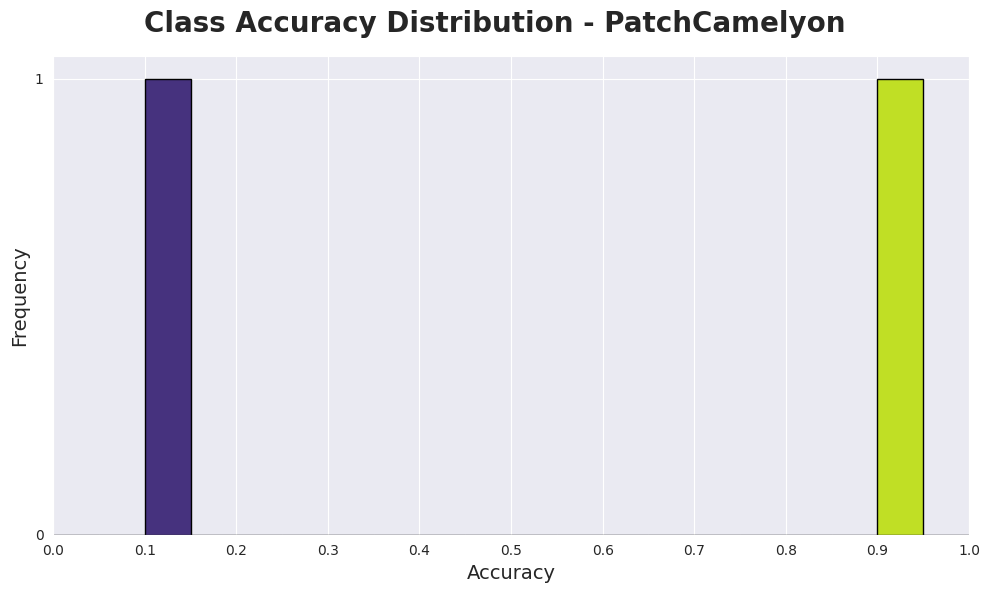

In [114]:
plot_per_class_accuracies(
    pcam_per_class_acc,
    'PatchCamelyon',
    num_bins=20
)

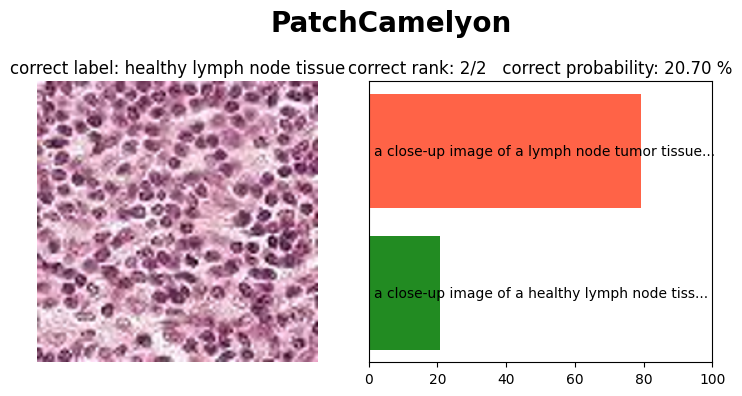

In [115]:
visualize_zero_shot_predict(
    model=model, 
    image=pcam.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=pcam.get_captions(),
    labels=pcam.get_labels(),
    label=pcam.get_label(id),
    prompt=pcam.get_prompt(),
    title='PatchCamelyon',
    config=config
)

#### SUN397

In [116]:
sun397.set_prompt("a clear photo capturing a {}.")

In [117]:
sun397_loss, sun397_acc, sun397_per_class_acc = evaluate_model(
    model,
    sun397,
    config,
    zero_shot=True
)

100%|██████████| 2719/2719 [04:27<00:00, 10.18it/s]


Zero-shot evaluation completed: loss: 1.4617 | acc: 0.5945


In [118]:
sun397_accs.append(sun397_acc)

In [119]:
get_top_5_accuracies(sun397_per_class_acc)

[('batters box', 1.0),
 ('crevasse', 1.0),
 ('landing deck', 1.0),
 ('rock arch', 1.0),
 ('sauna', 1.0)]

In [120]:
get_bottom_5_accuracies(sun397_per_class_acc)

[('berth', 0.0),
 ('conference center', 0.0),
 ('pavilion', 0.0),
 ('reception', 0.0),
 ('we bar', 0.0)]

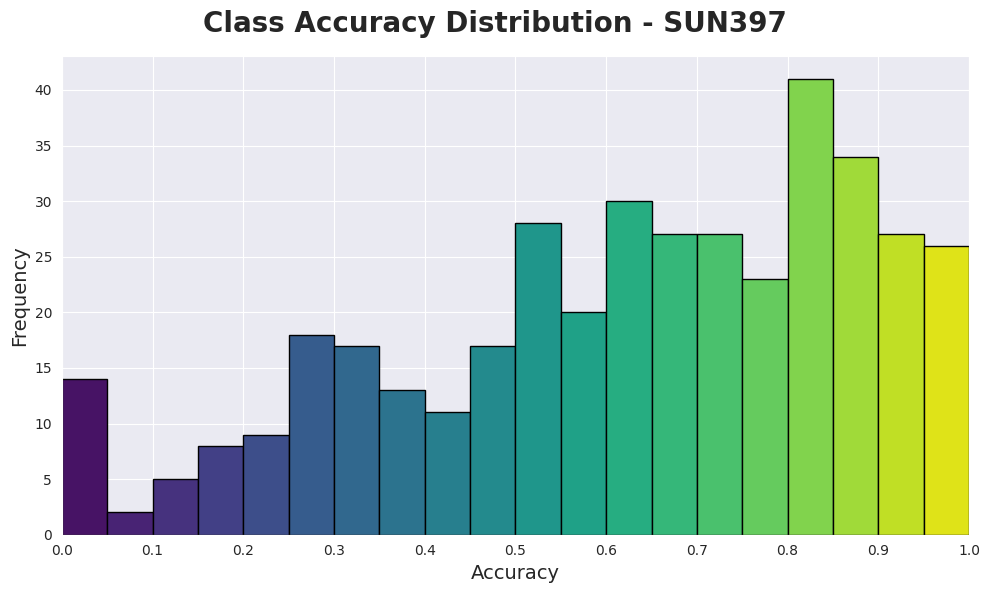

In [121]:
plot_per_class_accuracies(
    sun397_per_class_acc,
    'SUN397',
    num_bins=20
)

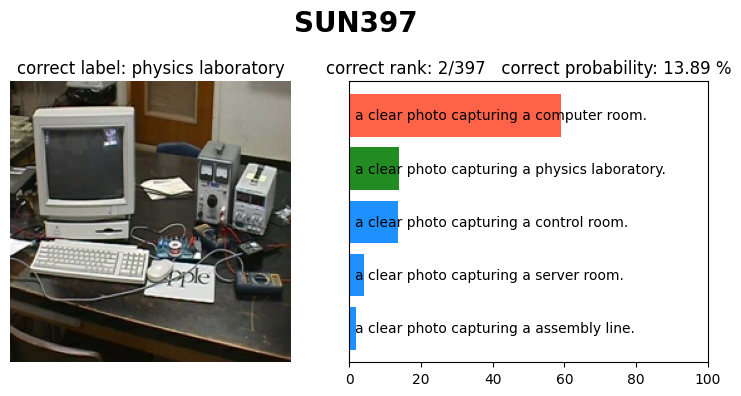

In [122]:
visualize_zero_shot_predict(
    model=model, 
    image=sun397.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=sun397.get_captions(),
    labels=sun397.get_labels(),
    label=sun397.get_label(id),
    prompt=sun397.get_prompt(),
    title='SUN397',
    config=config,
)

#### DTD

In [123]:
dtd.set_prompt("a detailed photo of a {} pattern.")

In [124]:
dtd_loss, dtd_acc, dtd_per_class_acc = evaluate_model(
    model,
    dtd,
    config,
    zero_shot=True
)

100%|██████████| 235/235 [00:15<00:00, 15.27it/s]

Zero-shot evaluation completed: loss: 2.0245 | acc: 0.4622


In [125]:
dtd_accs.append(dtd_acc)

In [126]:
get_top_5_accuracies(dtd_per_class_acc)

[('crystalline', 1.0),
 ('cobwebbed', 0.95),
 ('paisley', 0.925),
 ('polka-dotted', 0.925),
 ('studded', 0.925)]

In [127]:
get_bottom_5_accuracies(dtd_per_class_acc)

[('bumpy', 0.0),
 ('dotted', 0.0),
 ('flecked', 0.0),
 ('interlaced', 0.0),
 ('lacelike', 0.0)]

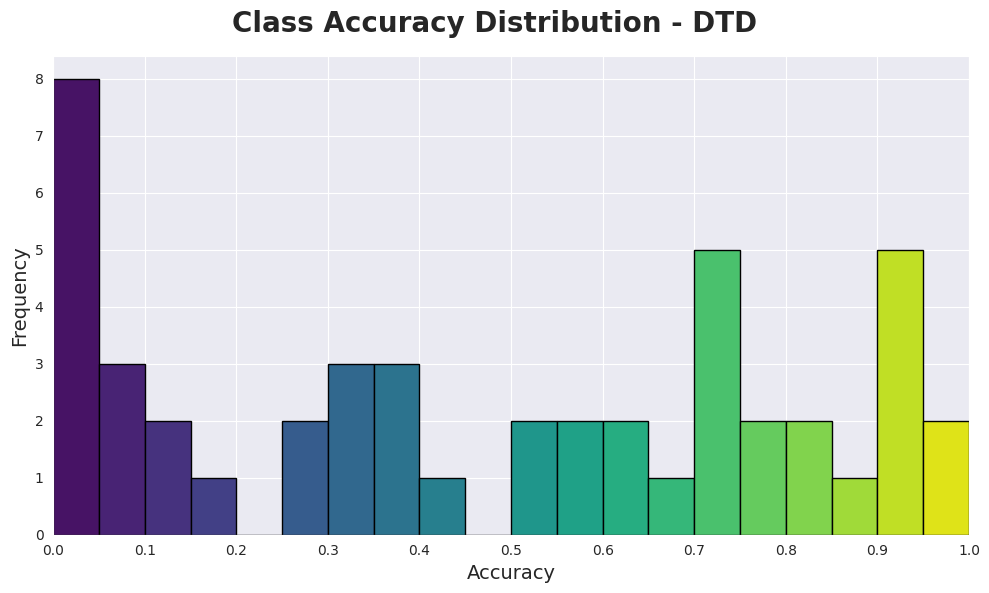

In [128]:
plot_per_class_accuracies(
    dtd_per_class_acc,
    'DTD',
    num_bins=20
)

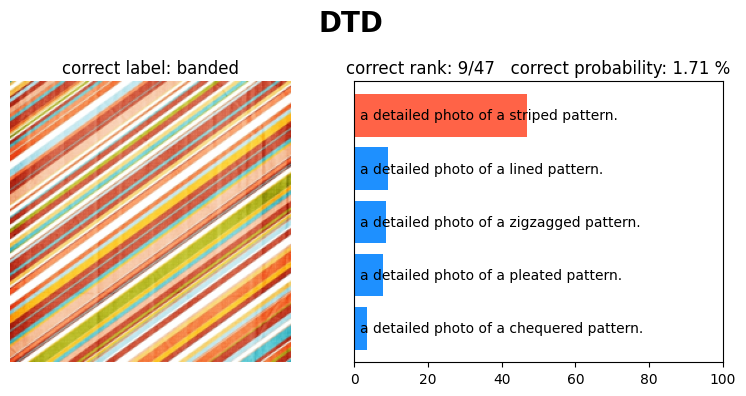

In [129]:
visualize_zero_shot_predict(
    model=model, 
    image=dtd.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=dtd.get_captions(),
    labels=dtd.get_labels(),
    label=dtd.get_label(id),
    prompt=dtd.get_prompt(),
    title='DTD',
    config=config
)

### Experiment #4 - OpenAI template

This experiment involes using prompt templates from OpenAI's official blog on CLIP.

https://openai.com/index/clip/

NOTE: Due to pre-processing, prompts may vary slighty.

Templates used:
- **RESISC45** - satellite imagery of {}.
- **Food-101** - a photo of {}, a type of food.
- **FER2013** - a photo of a {} looking face.
- **PCam** - this is a photo of {}
- **SUN397** - a photo of a {}.
- **DTD** - a photo of a {} texture.

#### RESISC45

In [130]:
resisc45.set_prompt("satellite imagery of {}.")

In [131]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = evaluate_model(
    model,
    resisc45,
    config,
    zero_shot=True
)

100%|██████████| 788/788 [00:36<00:00, 21.87it/s]

Zero-shot evaluation completed: loss: 1.2501 | acc: 0.6163


In [132]:
resisc45_accs.append(resisc45_acc)

In [133]:
get_top_5_accuracies(resisc45_per_class_acc)

[('golf course', 0.9918032786885246),
 ('parking lot', 0.9777777777777777),
 ('beach', 0.9538461538461539),
 ('bridge', 0.9285714285714286),
 ('baseball diamond', 0.926829268292683)]

In [134]:
get_bottom_5_accuracies(resisc45_per_class_acc)

[('chaparral', 0.007575757575757576),
 ('ground track field', 0.06299212598425197),
 ('commercial area', 0.06428571428571428),
 ('terrace', 0.07874015748031496),
 ('airplane', 0.10650887573964497)]

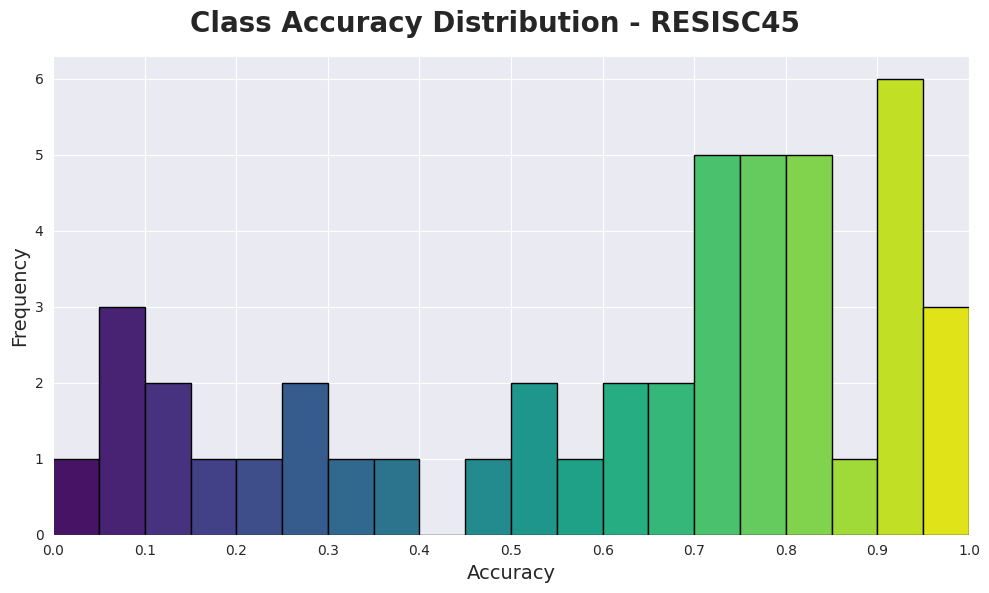

In [135]:
plot_per_class_accuracies(
    resisc45_per_class_acc,
    'RESISC45',
    num_bins=20
)

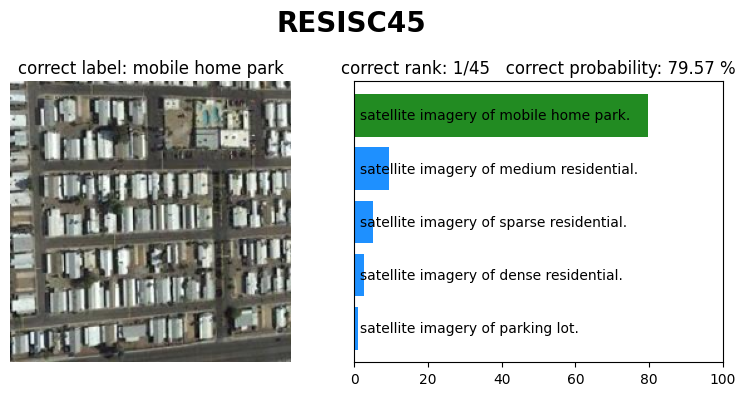

In [136]:
visualize_zero_shot_predict(
    model=model, 
    image=resisc45.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=resisc45.get_captions(),
    labels=resisc45.get_labels(),
    label=resisc45.get_label(id),
    prompt=resisc45.get_prompt(),
    title='RESISC45',
    config=config,
) 

#### Food-101

In [137]:
food101.set_prompt("a photo of {}, a type of food.")

In [138]:
food101_loss, food101_acc, food101_per_class_acc = evaluate_model(
    model,
    food101,
    config,
    zero_shot=True
)

 15%|█▌        | 474/3157 [00:32<03:02, 14.74it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 3157/3157 [03:40<00:00, 14.29it/s]


Zero-shot evaluation completed: loss: 0.3881 | acc: 0.8874


In [139]:
food101_accs.append(food101_acc)

In [140]:
get_top_5_accuracies(food101_per_class_acc)

[('edamame', 1.0),
 ('caesar salad', 0.988),
 ('oysters', 0.988),
 ('frozen yogurt', 0.984),
 ('lobster roll sandwich', 0.984)]

In [141]:
get_bottom_5_accuracies(food101_per_class_acc)

[('steak', 0.348),
 ('ice cream', 0.648),
 ('foie gras', 0.696),
 ('cup cakes', 0.72),
 ('tacos', 0.724)]

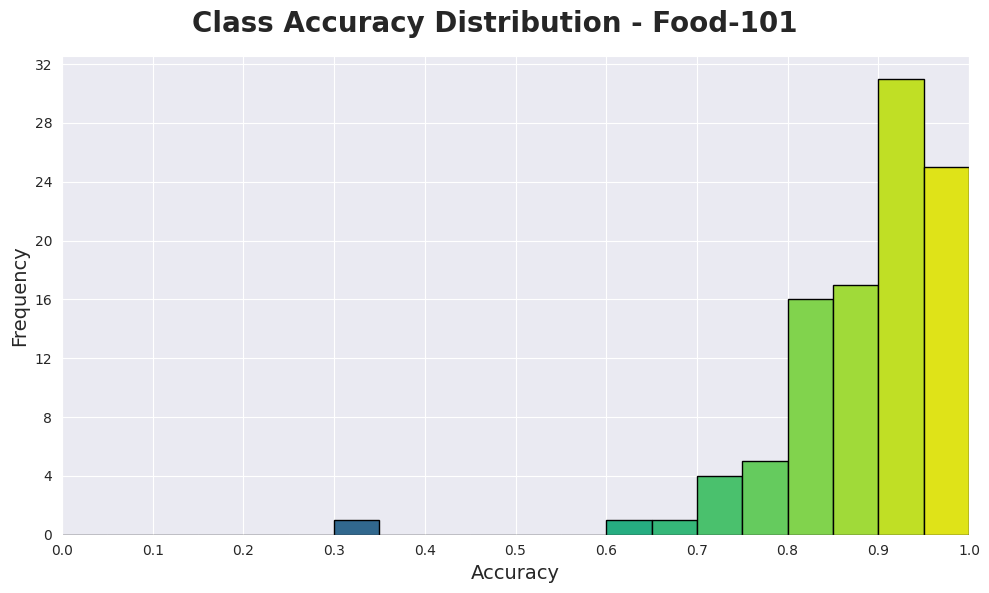

In [142]:
plot_per_class_accuracies(
    food101_per_class_acc,
    'Food-101',
    num_bins=20
)

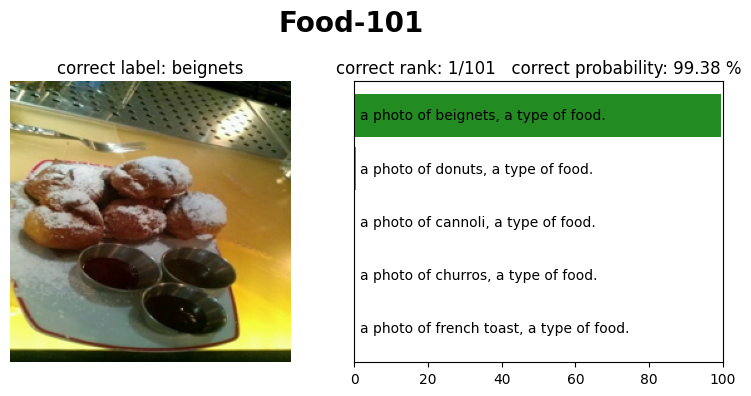

In [143]:
visualize_zero_shot_predict(
    model=model, 
    image=food101.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=food101.get_captions(),
    labels=food101.get_labels(),
    label=food101.get_label(id),
    prompt=food101.get_prompt(),
    title='Food-101',
    config=config
) 

#### FER2013

In [144]:
fer2013.set_prompt("a photo of a {} looking face.")

In [145]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = evaluate_model(
    model,
    fer2013,
    config,
    zero_shot=True
)

100%|██████████| 449/449 [00:16<00:00, 27.17it/s]

Zero-shot evaluation completed: loss: 1.4787 | acc: 0.4352


In [146]:
fer2013_accs.append(fer2013_acc)

In [147]:
fer2013_per_class_acc

{'angry': 0.5234215885947047,
 'disgust': 0.14545454545454545,
 'fear': 0.615530303030303,
 'happy': 0.6939704209328783,
 'sad': 0.29292929292929293,
 'surprise': 0.15144230769230768,
 'neutral': 0.19968051118210864}

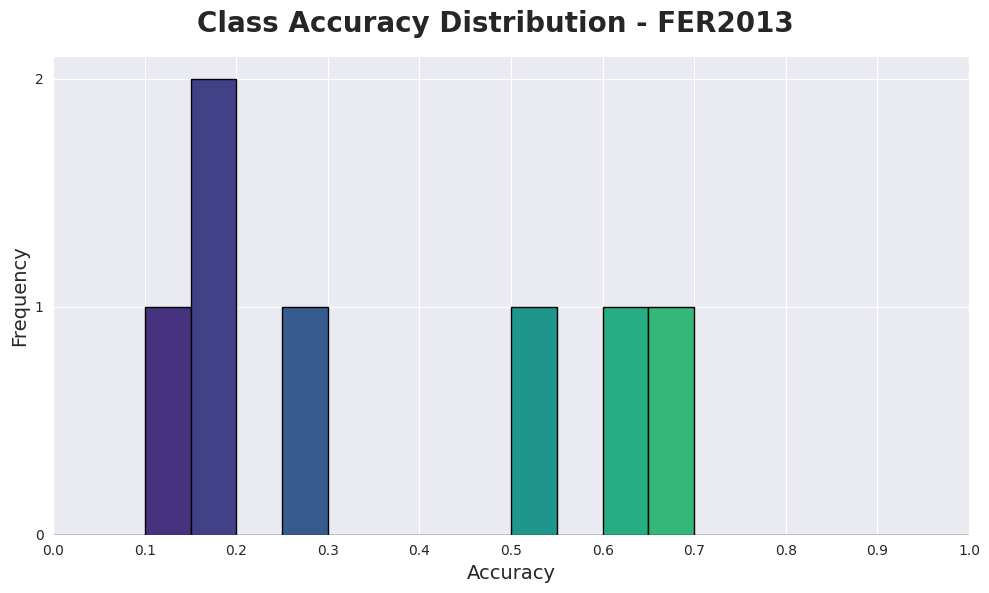

In [148]:
plot_per_class_accuracies(
    fer2013_per_class_acc,
    'FER2013',
    num_bins=20
)

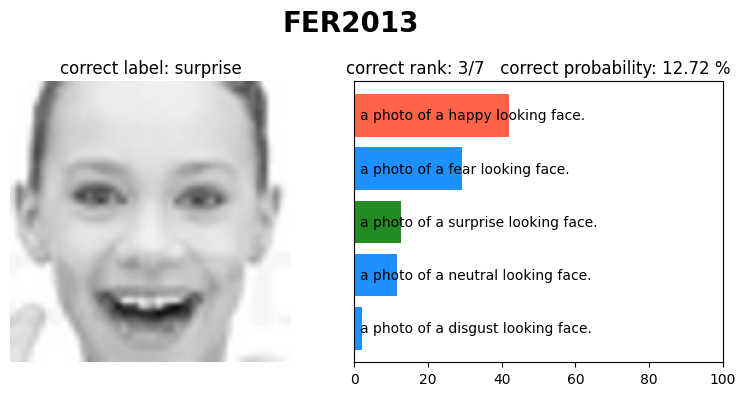

In [149]:
visualize_zero_shot_predict(
    model=model, 
    image=fer2013.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=fer2013.get_captions(),
    labels=fer2013.get_labels(),
    label=fer2013.get_label(id),
    prompt=fer2013.get_prompt(),
    title='FER2013',
    config=config
)

#### PCam

In [150]:
pcam.set_prompt("this is a photo of {}")

In [151]:
pcam_loss, pcam_acc, pcam_per_class_acc = evaluate_model(
    model,
    pcam,
    config,
    zero_shot=True
)

100%|██████████| 4096/4096 [02:39<00:00, 25.61it/s]

Zero-shot evaluation completed: loss: 0.6938 | acc: 0.5408


In [152]:
pcam_accs.append(pcam_acc)

In [153]:
pcam_per_class_acc

{'healthy lymph node tissue': 0.4505521322677079,
 'lymph node tumor tissue': 0.6311900836539048}

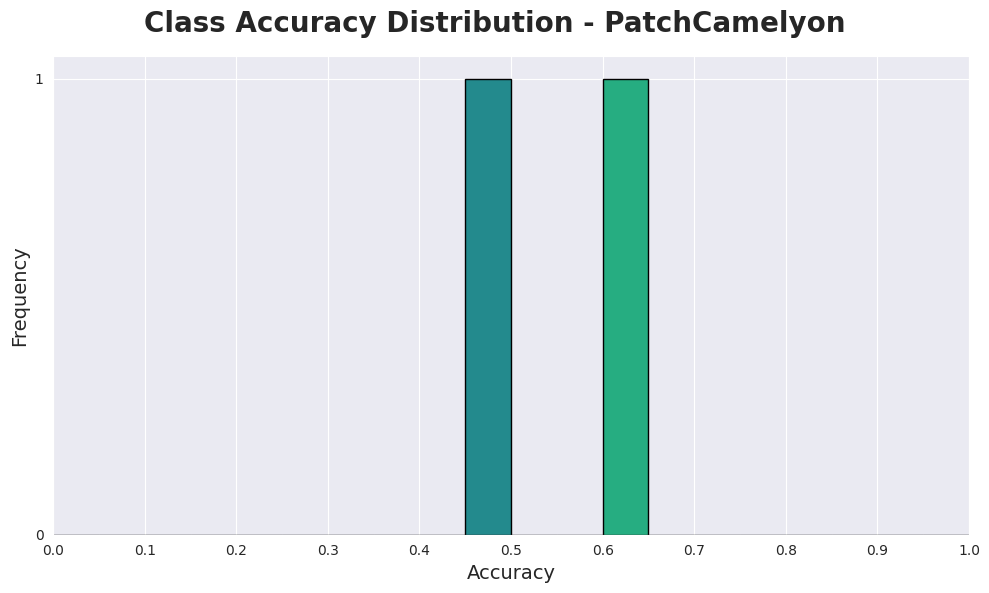

In [154]:
plot_per_class_accuracies(
    pcam_per_class_acc,
    'PatchCamelyon',
    num_bins=20
)

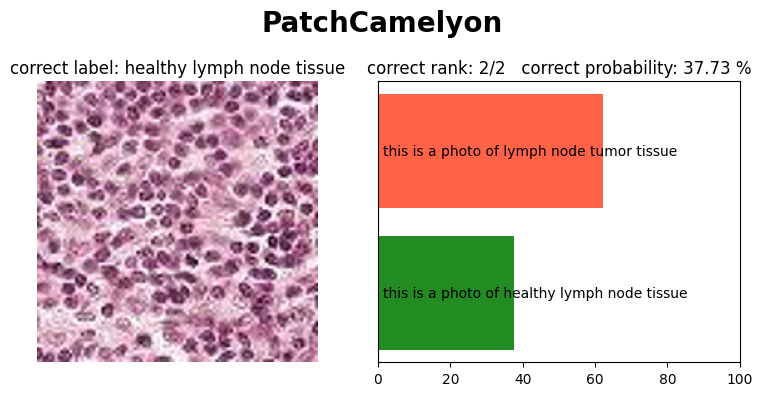

In [155]:
visualize_zero_shot_predict(
    model=model, 
    image=pcam.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=pcam.get_captions(),
    labels=pcam.get_labels(),
    label=pcam.get_label(id),
    prompt=pcam.get_prompt(),
    title='PatchCamelyon',
    config=config
)

#### SUN397

In [156]:
sun397.set_prompt("a photo of a {}.")

In [157]:
sun397_loss, sun397_acc, sun397_per_class_acc = evaluate_model(
    model,
    sun397,
    config,
    zero_shot=True
)

100%|██████████| 2719/2719 [04:22<00:00, 10.36it/s]


Zero-shot evaluation completed: loss: 1.3989 | acc: 0.6065


In [158]:
sun397_accs.append(sun397_acc)

In [159]:
get_top_5_accuracies(sun397_per_class_acc)

[('cubicle (office)', 1.0),
 ('heliport', 1.0),
 ('landing deck', 1.0),
 ('rock arch', 1.0),
 ('sauna', 1.0)]

In [160]:
get_bottom_5_accuracies(sun397_per_class_acc)

[('berth', 0.0),
 ('conference center', 0.0),
 ('library (outdoor)', 0.0),
 ('pavilion', 0.0),
 ('reception', 0.0)]

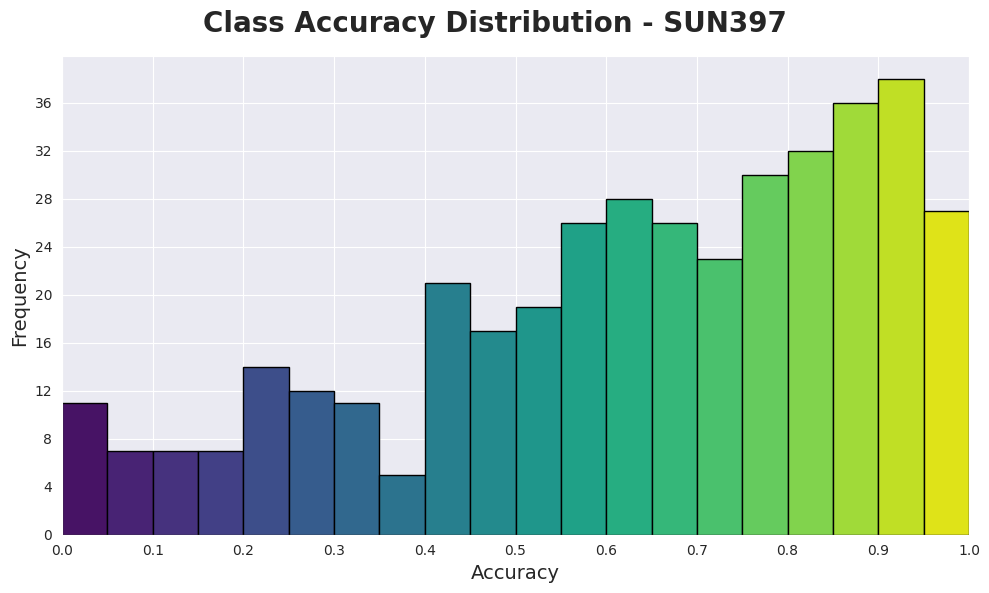

In [161]:
plot_per_class_accuracies(
    sun397_per_class_acc,
    'SUN397',
    num_bins=20
)

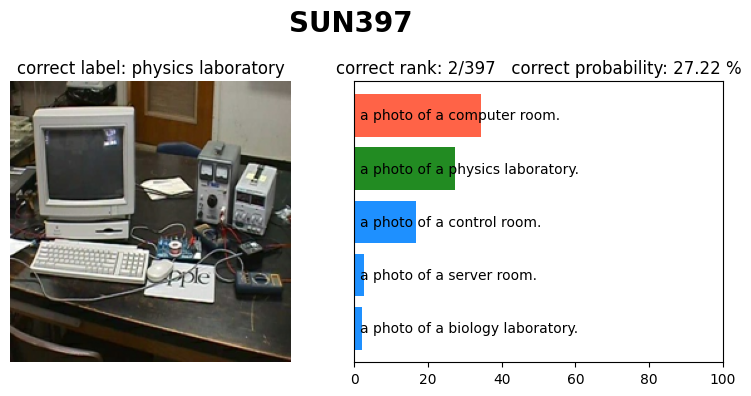

In [162]:
visualize_zero_shot_predict(
    model=model, 
    image=sun397.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=sun397.get_captions(),
    labels=sun397.get_labels(),
    label=sun397.get_label(id),
    prompt=sun397.get_prompt(),
    title='SUN397',
    config=config,
)

#### DTD

In [163]:
dtd.set_prompt("a photo of a {} texture.")

In [164]:
dtd_loss, dtd_acc, dtd_per_class_acc = evaluate_model(
    model,
    dtd,
    config,
    zero_shot=True
)

100%|██████████| 235/235 [00:15<00:00, 15.10it/s]


Zero-shot evaluation completed: loss: 2.0945 | acc: 0.4293


In [165]:
dtd_accs.append(dtd_acc)

In [166]:
get_top_5_accuracies(dtd_per_class_acc)

[('chequered', 1.0),
 ('crystalline', 0.975),
 ('knitted', 0.975),
 ('paisley', 0.975),
 ('bubbly', 0.95)]

In [167]:
get_bottom_5_accuracies(dtd_per_class_acc)

[('dotted', 0.0),
 ('flecked', 0.0),
 ('lacelike', 0.0),
 ('potholed', 0.0),
 ('grooved', 0.025)]

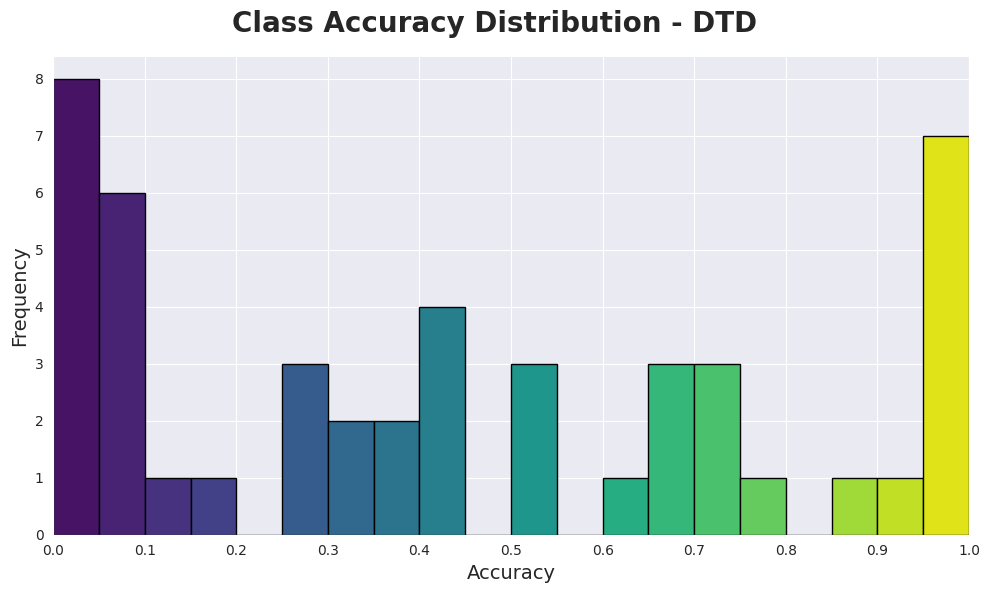

In [168]:
plot_per_class_accuracies(
    dtd_per_class_acc,
    'DTD',
    num_bins=20
)

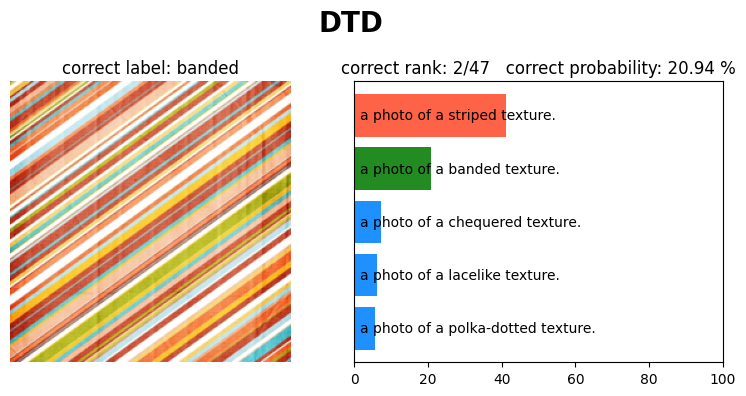

In [169]:
visualize_zero_shot_predict(
    model=model, 
    image=dtd.get_image(id),
    processor=processor,
    tokenizer=tokenizer,
    captions=dtd.get_captions(),
    labels=dtd.get_labels(),
    label=dtd.get_label(id),
    prompt=dtd.get_prompt(),
    title='DTD',
    config=config
)

### Results

Display the results of the analysis in dataframe.

In [170]:
labels = ['RESISC45', 'Food-101', 'FER2013', 'PatchCamelyon', 'SUN397', 'DTD']
experiments = ['Class label', 'Basic template', 'Custom template', 'OpenAI template']
results = [
    resisc45_accs,
    food101_accs,
    fer2013_accs,
    pcam_accs,
    sun397_accs,
    dtd_accs,
]

In [171]:
acc_dict = create_accuracy_dict(
    results,
    labels
)

Create a dataframe that shows results for each dataset in each experiment.

Last three columns show the relative change between the three experiments and the base one (class label).

In [172]:
df = pd.DataFrame(results, columns=experiments, index=labels)
df['Basic template (% Δ)'] = ((df['Basic template'] - df['Class label']) * 100).round(2)
df['Custom template (% Δ)'] = ((df['Custom template'] - df['Class label']) * 100).round(2)
df['OpenAI template (% Δ)'] = ((df['OpenAI template'] - df['Class label']) * 100).round(2)
df

Class label  Basic template  Custom template  OpenAI template  \
RESISC45          0.543968        0.565714         0.595556         0.616349   
Food-101          0.866693        0.865703         0.884911         0.887366   
FER2013           0.408470        0.454723         0.458624         0.435219   
PatchCamelyon     0.558472        0.553802         0.536652         0.540833   
SUN397            0.610943        0.639218         0.594529         0.606483   
DTD               0.446809        0.409043         0.462234         0.429255   

               Basic template (% Δ)  Custom template (% Δ)  \
RESISC45                       2.17                   5.16   
Food-101                      -0.10                   1.82   
FER2013                        4.63                   5.02   
PatchCamelyon                 -0.47                  -2.18   
SUN397                         2.83                  -1.64   
DTD                           -3.78                   1.54   

               OpenAI template (% Δ)  
RESISC45                        7.24  
Food-101                        2.07  
FER2013                         2.67  
PatchCamelyon                  -1.76  
SUN397                         -0.45  
DTD                            -1.76